# Feature Generation

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm
import joblib

from Alpha_Research import Alpha_Research
from Formulaic_Alpha import *

In [2]:
alpha_dict = dict()
ar = Alpha_Research()

## Accounting Features

In [3]:
features = [ts_last_change(ar.m['ROA'], 6)]
def operation(x):
    return rank(x[0])
alpha_dict['roa_change_6'] = ar.backtest(features, operation)

In [4]:
features = [ts_last_change(ar.m['OPM'])]
def operation(x):
    return rank(x[0])
alpha_dict['opm_change'] = ar.backtest(features, operation)

In [5]:
features = [-ts_last_pct(ar.m['A'], 12)]
def operation(x):
    return rank(x[0])
alpha_dict['a_pct_12'] = ar.backtest(features, operation)

In [6]:
features = [ts_last_change(ar.m['SG'])]
def operation(x):
    return rank(x[0])
alpha_dict['sg_change'] = ar.backtest(features, operation)

In [7]:
features = [ar.m['OPG']]
def operation(x):
    return rank(x[0])
alpha_dict['opg'] = ar.backtest(features, operation)

In [8]:
features = [ar.m['GPG']]
def operation(x):
    return rank(x[0])
alpha_dict['gpg'] = ar.backtest(features, operation)

In [9]:
features = [-ts_last_change(ar.m['DIV'])]
def operation(x):
    return rank(x[0])
alpha_dict['div_change'] = ar.backtest(features, operation)

In [10]:
features = [ts_last_pct(ar.m['GP'])]
def operation(x):
    return rank(x[0])
alpha_dict['gp_pct'] = ar.backtest(features, operation)

In [11]:
features = [-ts_last_change(ar.m['OPM']/ar.m['ROA'])]
def operation(x):
    return rank(x[0])
alpha_dict['opm_roa_change'] = ar.backtest(features, operation)

## Market Features

In [12]:
features = [ts_change(ar.m['VOL20'], 1)]
def operation(x):
    return rank(x[0])
alpha_dict['vol20_change'] = ar.backtest(features, operation)

In [13]:
features = [ts_pct(ar.m['V20'], 1)]
def operation(x):
    return rank(x[0])
alpha_dict['v20_pct'] = ar.backtest(features, operation)

In [14]:
y = ar.d['ADJC']
x = ts_delay(y, 1)

window = 60
beta = ts_slope(x, y, 60)

se = ts_std(y - beta * x, window)

t_stat = beta / (se / (window - 2) ** 0.5)
t_stat = to_monthly(t_stat)

features = [t_stat]
def operation(x):
    return rank(x[0])
alpha_dict['ar1_tstat'] = ar.backtest(features, operation)

In [15]:
y = ar.d['ADJC']
x = y.shift(1)

window = 60
ar1_corr = x.rolling(window).corr(y)
ar1_corr = to_monthly(ar1_corr)

features = [ar1_corr]
def operation(x):
    return rank(x[0])
alpha_dict['ar1_corr'] = ar.backtest(features, operation)

## Alpha Pool Analysis

opg and gpg have correlation: 0.61
vol20_change and v20_pct have correlation: 0.55
roa_change_6 and opm_change have correlation: 0.55
opm_change and gp_pct have correlation: 0.51
a_pct_12 and ar1_tstat have correlation: 0.50
                 2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  \
Min Long Count     62    62    60    62    81    79    87    95    96    89   
Min Short Count    68    62    61    67    81    84    89    93    95    97   

                 2020  2021  2022  2023  
Min Long Count     95    91    91    94  
Min Short Count    96    94    94    98  


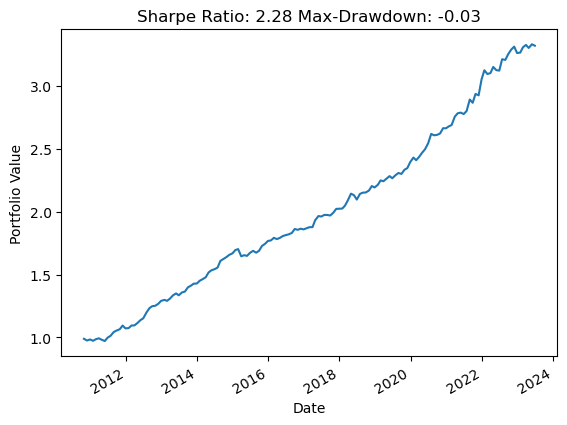

In [16]:
ar.alpha_pool(alpha_dict)

## Training Data Stacking

In [17]:
stack_list = []
for ticker in tqdm(ar.df_target.columns):
    temp_dict = dict()
    for alpha in list(alpha_dict.keys()):
        try:
            temp_dict[alpha] = alpha_dict[alpha][1][ticker]
        except KeyError:
            pass
    
    temp_dict['fgsc'] = ar.fgsc[ticker]
    temp_dict['year'] = [i.year for i in list(ar.df_target.index)]
    temp_dict['month'] = [i.month for i in list(ar.df_target.index)]
    temp_dict['target'] = ar.df_target[ticker]

    df_temp = pd.DataFrame(temp_dict)
    df_temp.reset_index(inplace=True)
    df_temp.rename(columns={'index':'Date'}, inplace=True)
    df_temp['Ticker'] = ticker # for index

    df_temp.set_index(['Date', 'Ticker'], inplace=True)
    stack_list.append(df_temp)

100%|███████████████████████████████████████████████████████████████████████████████| 526/526 [00:01<00:00, 280.47it/s]


In [18]:
df_stack = pd.DataFrame()
df_stack = pd.concat(stack_list, axis=0)
df_stack = df_stack[df_stack.iloc[:,:-1].notnull().sum(axis=1)>5]
df_stack = df_stack[~df_stack.iloc[:,-1].isna()]
LB = np.percentile(df_stack.iloc[:,-1], 1)
UB = np.percentile(df_stack.iloc[:,-1], 99)
df_stack['target'] = df_stack['target'].clip(lower=LB, upper=UB)
df_stack.sort_index(inplace=True)
df_stack['fgsc'] = df_stack['fgsc'].astype("category")
new_list = list(df_stack.columns[-4:-1]) + list(df_stack.columns)[:-4] + ['target']
df_stack = df_stack[new_list]

In [19]:
# demean by date and sector
demean_list = []
for dt in tqdm(ar.df_target.index):
    for sc in ar.fgsc.unique():
        temp = df_stack.loc[(dt, slice(None)), :].copy()
        temp = temp[temp['fgsc']==sc]
        temp['target'] = temp['target'].sub(temp['target'].mean())
        demean_list.append(temp)
df_stack = pd.concat(demean_list, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:01<00:00, 91.75it/s]


In [20]:
data_path = "data"
stack_name = os.path.join(data_path, "data_stack.h5")
df_stack.to_hdf(stack_name, key='df', mode='w', format="table")